# Test our Ecohydrology module

This notebook is to test that importing and using our implementation of the Ecohydrology model works. 

In [16]:
from ecohydr_mod import EcoHyd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
def get_yearly_temp(csv_path, num_years):
    df = pd.read_csv(csv_path)
    df.dt = pd.to_datetime(df.dt)
    avg_temp_per_year = []
    max_temp_per_year = []
    min_temp_per_year = []
    for year in range(0, num_years):
        earliest_yr = df.iloc[0, 0].year
        year = year + earliest_yr
        if len(df.loc[(df.dt.dt.year == year), :]) > 365:
            avg_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'AverageTemperature'].iloc[:-1].tolist())
            max_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MaxTemperature'].iloc[:-1].tolist())
            min_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MinTemperature'].iloc[:-1].tolist())
        else:
            avg_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'AverageTemperature'].tolist())
            max_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MaxTemperature'].tolist())
            min_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MinTemperature'].tolist())
    
    return avg_temp_per_year, max_temp_per_year, min_temp_per_year

In [18]:
#set model config options
current={
            #----------------#
            # dry season dates #
            'canicula_start':0,
            'canicula_end':140, 
            'canicula_start_expected':0,
            'canicula_end_expected':140, 
            #----------------#
            # rainfall stats #
            # Times are all in hours.
            'mean_interstorm_wet':4*24,
            'mean_storm_wet':2*24,
            'mean_raindpth_wet':10,
            'mean_interstorm_dry':10*24,
            'mean_storm_dry':0.5*24,
            'mean_raindpth_dry':1,
            #-------------------#
            # temperature shift #
            'tempshift':np.array(365*[0.])
        }

#have two plausible versions of this that we switch between.

warm={
            #----------------#
            # Canicula dates #
            'canicula_start':0,
            'canicula_end':160, 
            'canicula_start_expected':0,
            'canicula_end_expected':140, 
            #----------------#
            # rainfall stats #
            # Times are all in hours.
            'mean_interstorm_wet':8*24,
            'mean_storm_wet':3*24,
            'mean_raindpth_wet':15,
            'mean_interstorm_dry':10*24,
            'mean_storm_dry':0.5*24,
            'mean_raindpth_dry':1,
            #-------------------#
            # temperature shift #
            'tempshift':np.array(365*[2.])
        }

#get input temperature data
avg, maxi, mini = get_yearly_temp('new_temp_data.csv', 10)
avg = np.array(avg)
maxi = np.array(maxi)
mini = np.array(mini)


In [19]:
WSA_array = np.zeros((51,51))
# Set 20 random values to 1
indices_to_set = np.random.choice(range(51 * 51), size=20, replace=False)
row_indices, col_indices = np.unravel_index(indices_to_set, (51, 51))
WSA_array[row_indices, col_indices] = int(1)

climate = current

Ecohyd_model = EcoHyd(climate, 20, 26, 23)

In [20]:
biomass_harvest, SM_canic_end = Ecohyd_model.stepper(WSA_array, avg[0]+climate['tempshift'], maxi[0]+climate['tempshift'], mini[0]+climate['tempshift'])

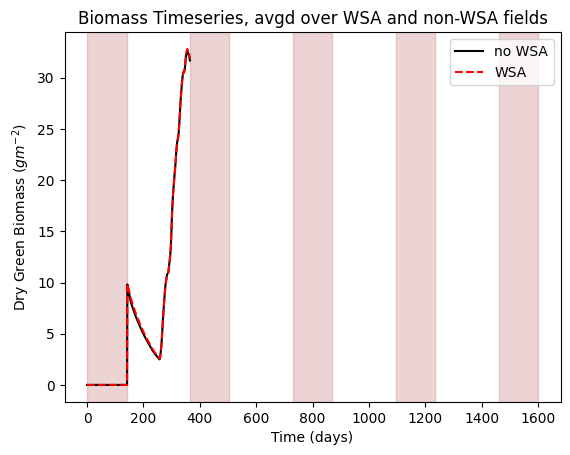

In [21]:
plt.plot(Ecohyd_model.noWSA_biomass_tseries, label = 'no WSA', color= 'black')
plt.plot(Ecohyd_model.WSA_biomass_tseries, label = 'WSA', color= 'red', linestyle = '--')
plt.title('Biomass Timeseries, avgd over WSA and non-WSA fields')
plt.xlabel('Time (days)')
plt.ylabel(r'Dry Green Biomass ($gm^{-2}$)')
for i in range(0, 5):
    plt.axvspan(i*365, 140 + i*365, color='brown', alpha=0.2)
    #plt.axvspan(140 + i*365, (i+1)*365, color='blue', alpha=0.2)

plt.legend()

#plt.savefig('/Users/benjaminbuchenau/Documents/GitHub/TreesAndThat/biomass_tseries_current.pdf')

The first 100 days after the end of the canicula are puzzling - the plants just seem to die off with no growth!

Another issue is that the farmers are assumed to just know when the dry season ends. I we want to make this variable, that's an issue, because the element of surprise is needed...

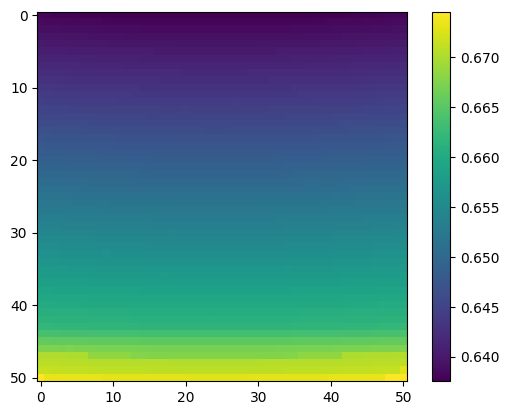

In [22]:
plt.imshow(np.reshape(Ecohyd_model.mg.at_cell['vegetation__cover_fraction'], (51,51)))
plt.colorbar()

In [23]:
Ecohyd_model.mg.at_cell['vegetation__cover_fraction']

array([ 0.63803055,  0.63798984,  0.63795081, ...,  0.67446007,
        0.67449657,  0.6745345 ])

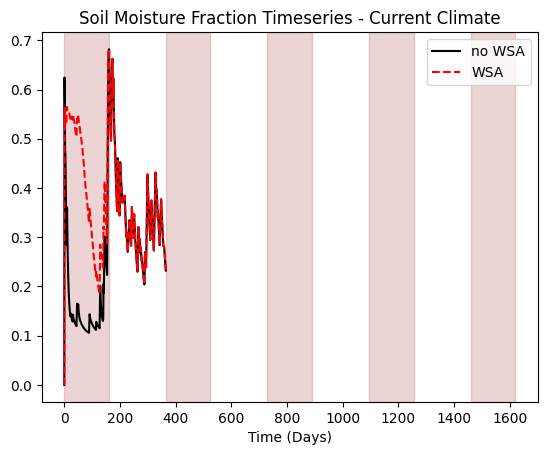

In [24]:
plt.plot(Ecohyd_model.noWSA_SM_tseries, label = 'no WSA', color= 'black')
plt.plot(Ecohyd_model.WSA_SM_tseries, label = 'WSA', color= 'red', linestyle = '--')
plt.title('Soil Moisture Fraction Timeseries - Current Climate')
plt.xlabel('Time (Days)')
for i in range(0, 5):
    plt.axvspan(i*365, 160 + i*365, color='brown', alpha=0.2)
plt.legend()

#plt.savefig('/Users/benjaminbuchenau/Documents/GitHub/TreesAndThat/SM_tseries_current.pdf')

WSA seems to have a clear impact on soil moisture retention initially, but that retention then drops sharply before the end of the Canicula. Why is this? In addition, it seems like the equilibrium soil mopisture is tzhe same in the dry and the wet season, suggesting actual rainfall amounts are the same between the two seasons. 

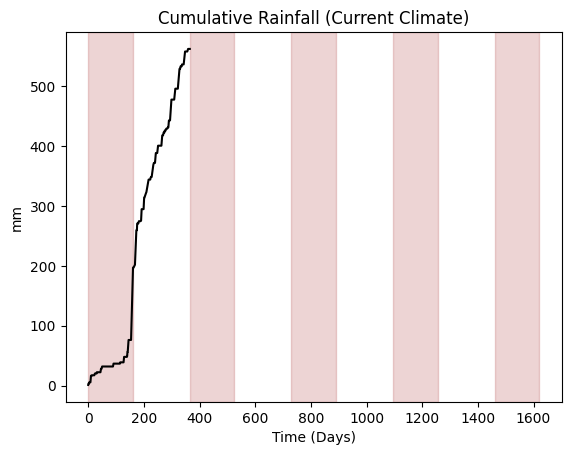

In [25]:
plt.plot(np.cumsum(Ecohyd_model.rain_tseries), color = 'black')
plt.title('Cumulative Rainfall (Current Climate)')
plt.xlabel('Time (Days)')
plt.ylabel('mm')

for i in range(0, 5):
    plt.axvspan(i*365, 160 + i*365, color='brown', alpha=0.2)

#plt.savefig('/Users/benjaminbuchenau/Documents/GitHub/TreesAndThat/rainfall_tseries_current.pdf')

In [26]:
year =6
rainfall = np.cumsum(Ecohyd_model.rain_tseries[(year)*365:(year+1)*365])[-1]
print(rainfall)

IndexError: index -1 is out of bounds for axis 0 with size 0

Somehow, the rainfall generator consistently produces less rain in the first few years, and always generates a little 'step' in the beginning of the wet season. This stabilises over the following years so should not be a concern as we are spinning the model up for 5 years in the full coupled runs, but it is strange regardless.

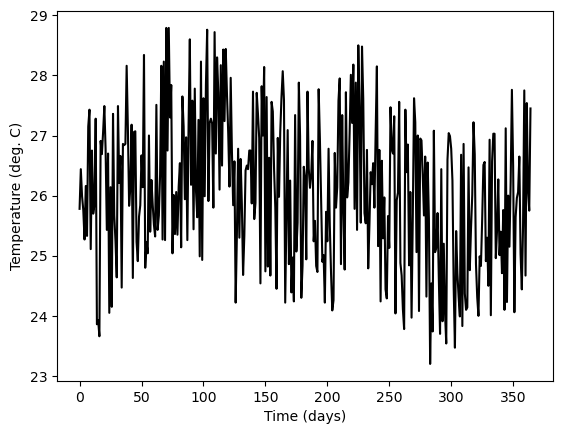

In [ ]:
plt.plot(avg[0], color = 'black')
plt.xlabel('Time (days)')
plt.ylabel('Temperature (deg. C)')
#plt.savefig('/Users/benjaminbuchenau/Documents/GitHub/TreesAndThat/temp_tseries_current.pdf')

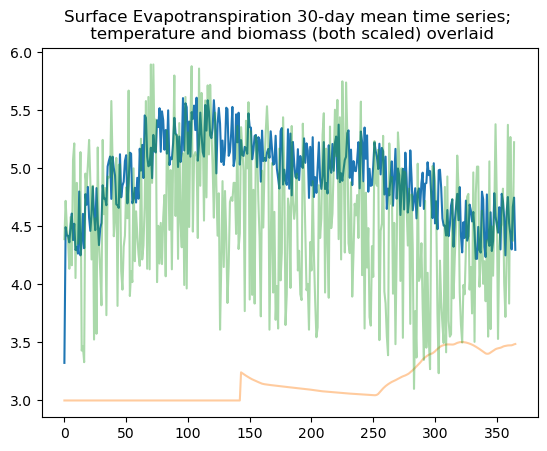

In [ ]:
plt.plot(Ecohyd_model.ET30_tseries)
plt.title('Surface Evapotranspiration 30-day mean time series; \n temperature and biomass (both scaled) overlaid')
plt.plot(np.array(Ecohyd_model.noWSA_biomass_tseries)/40+3, alpha = 0.4)
plt.plot(np.array(avg[0])/2-8.5, alpha = 0.4)
#plt.plot(np.array(avg[1])/2-8.5, alpha = 0.4)

Overlaying temperature, Evapotranspiration and biomass seems to suggest that the 'awakening' of plants coincides with the second maximum in temperature and ET. What this means I am not sure. Is something going wrong with the ET threshold, and we are accidentally using the non-growing-season threshold before this?

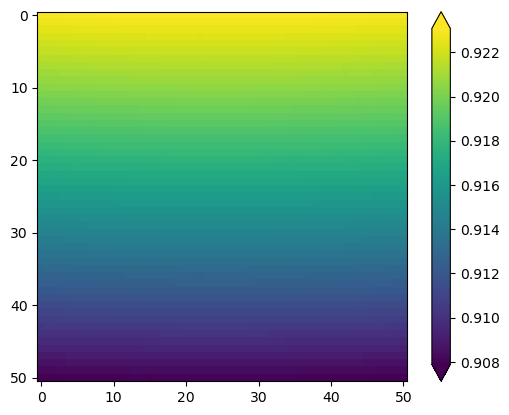

In [ ]:
plt.imshow(np.reshape(Ecohyd_model.mg.at_cell['surface__evapotranspiration'], (51,51)))
plt.colorbar(extend = 'both')

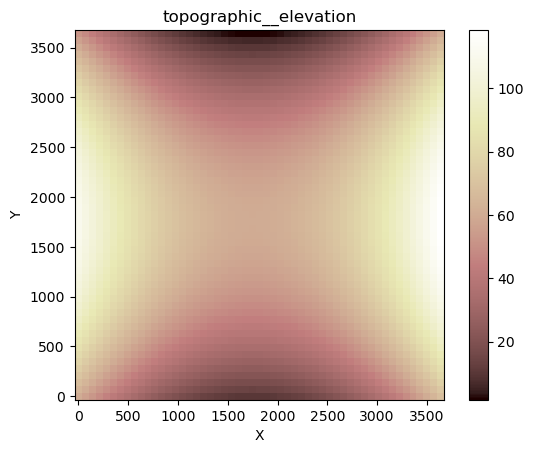

In [ ]:
from landlab.plot.imshow import imshow_grid_at_node
#N.B. the Landlab user guide tells you to import the wrong component here

plt.figure('Elevations from the field')  # new fig, with a name
imshow_grid_at_node(Ecohyd_model.mg, 'topographic__elevation') 
plt.show()

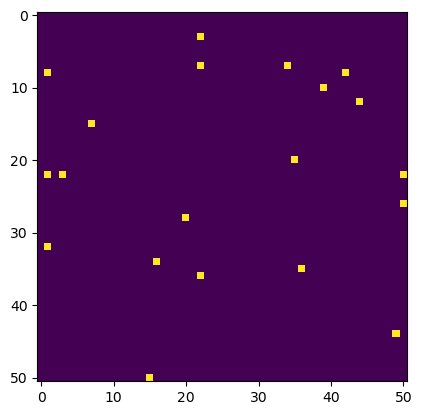

In [ ]:
plt.imshow(WSA_array)

N.B the following images are all flipped upside-down because np.reshape assumes by default that the origin is in the top left, not the bottom left.

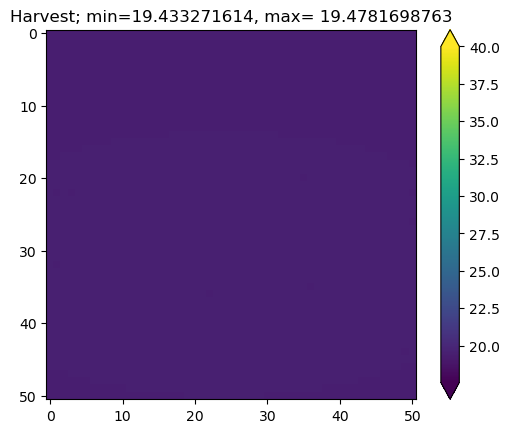

In [ ]:
plt.imshow(np.reshape(biomass_harvest, (51,51)), vmin=40)
hmin = np.min(biomass_harvest)
hmax = np.max(biomass_harvest)
plt.title('Harvest; min='+str(hmin)+', max= ' + str(hmax))

plt.colorbar(extend = 'both')

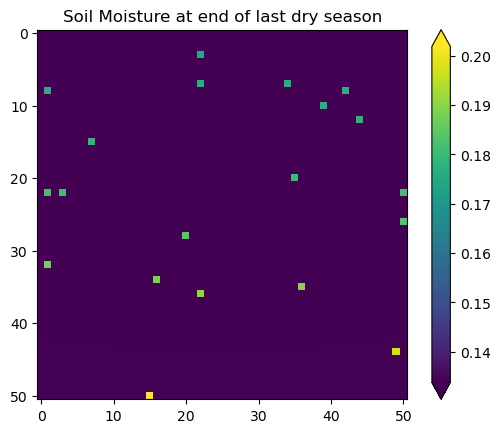

In [ ]:
plt.imshow(np.reshape(SM_canic_end, (51,51)))
plt.title('Soil Moisture at end of last dry season')
plt.colorbar(extend = 'both')

Why does WSA decrease soil moisture? A bit sus... Maybe there is still enough rainfall that the cover crop interception leads to less SM.

Almost more importantly though, we need to figure out what causes the weird artifact at the bottom of the plot (i.e., the North of the domain). Why is soil moisture there so much lower? As-is, this will dominate any potential effects from WSA.

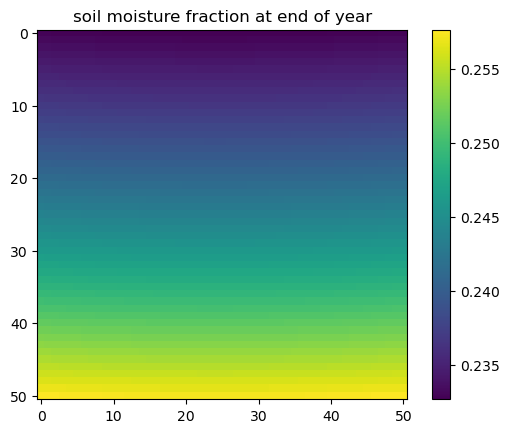

In [ ]:
SM = np.reshape(Ecohyd_model.mg.at_cell['soil_moisture__saturation_fraction'], (51,51))
plt.imshow(SM)
plt.title('soil moisture fraction at end of year')
plt.colorbar()

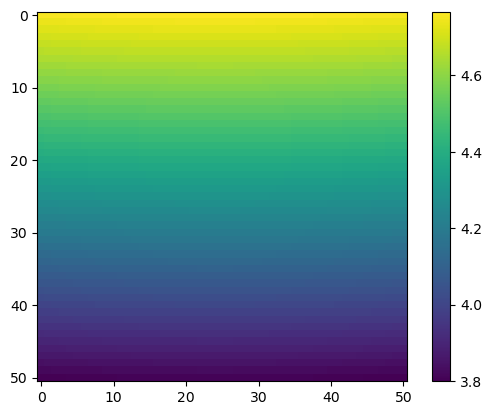

In [ ]:
ET = np.reshape(Ecohyd_model.mg.at_cell['surface__potential_evapotranspiration_rate'], (51,51))
plt.imshow(ET)
plt.colorbar()

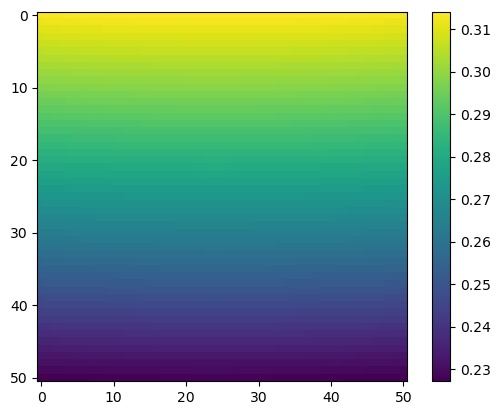

In [ ]:
WS = np.reshape(Ecohyd_model.mg.at_cell['vegetation__water_stress'], (51,51))
plt.imshow(WS)
plt.colorbar()

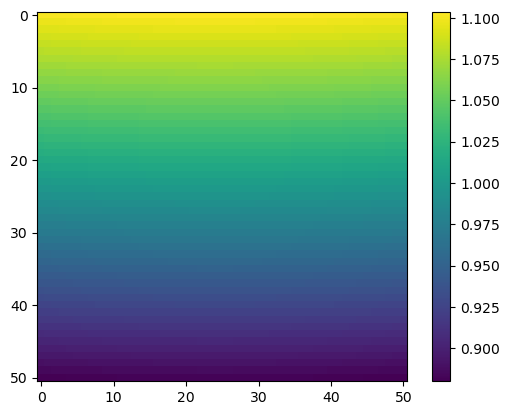

In [ ]:
Rad_slope = np.reshape(Ecohyd_model.mg.at_cell['radiation__ratio_to_flat_surface'], (51,51))
plt.imshow(Rad_slope)
plt.colorbar()